### 使用SASPy控制SAS，可以替代SAS中Macro寫法，使整體寫法更簡單且有效率

<img src="SASPy_submit_rundown.png" style="width:896px;height:200px;float:left">

+ ```資料```
1. **健保資料庫百萬歸⼈檔住院醫療明細檔(DD)、住院醫令檔(DO)** <br>
2. **2007年~2011年**
--------------------------------------------------------
+ ```⽬標對象```
1. **2008年患有缺⾎性⼼臟病(即⼼肌梗塞)者(ICD9-CM 診斷碼 : 410-414)**
2. **年齡65歲或以上**
3. **以當年度(2008年)最早診斷⽇期為 index date**
4. **住院主診斷碼、次診斷碼任⼀個診斷碼符合皆算確診**
--------------------------------------------------------
+ ```⽬標發⽣疾病```
1. **患有缺⾎性⼼臟病後(index date後)，發⽣腦⾎管疾病者，即是中風 (ICD9-CM 診斷碼 : 430-437)**
--------------------------------------------------------
+ ```過去病史，過去⼀年內曾被診斷```
1. **⾼⾎壓 (ICD9-CM 診斷碼 : 401-405)**
2. **⾼⾎糖 (ICD9-CM 診斷碼 : 250)**
3. **⾼⾎脂 (ICD9-CM 診斷碼 : 272)**
4. **慢性腎臟病 (ICD9-CM 診斷碼 : 585)**
5. **慢性阻塞性肺部疾病 (ICD9-CM 診斷碼 : 490-496)**
--------------------------------------------------------
+ ```過去⽤藥史```
1. **ANTIHYPERTENSIVES**
2. **bblocker**
3. **Metformin**
4. **Statin**
--------------------------------------------------------
+ ```產出 Table : 2008年患有缺⾎性⼼臟病的⼈```
1. **平均年齡(mean±SD)**
2. **性別(N, %)**
3. **過去病史(N, %)**
4. **過去⽤藥史(N, %)**
5. **發⽣中⾵((N, %)**
6. **診斷出心臟病與第一次發⽣中⾵的間隔時間，用以計算存活分析**
7. **計算2009、2010、2011這三年因中風而住院的天數計算**
8. **取出倒數第 n 筆資料(取倒數第2筆資料)**
--------------------------------------------------------

+ ```主要步驟```
1. **先從 2008DD 把有罹患缺血性心臟病的病患 ID Set 挑出來**
2. **用 2007DD+DO 找出過去病史與用藥史，用 ID Set 過濾**
3. **找出 2009 2010 2011 腦血管疾病者(中風)，用 ID Set 過濾**

In [1]:
import numpy as np
import pandas as pd
import os
from IPython.display import display, HTML

import sys
sys.path.insert(0 , 'C:\\Users\\Hong Guo-Peng\\Anaconda3\\lib\\site-packages')
import saspy
sas = saspy.SASsession()

Using SAS Config named: autogen_winlocal
SAS Connection established. Subprocess id is 13696

The SAS session encoding for this session (ms-950) doesn't have a known Python equivalent encoding.
Proceeding using the specified encoding of Big5-HKSCS, though you may encounter transcoding problems.



In [2]:
sas

Access Method         = IOM
SAS Config name       = autogen_winlocal
SAS Config file       = C:\Users\Hong Guo-Peng\Anaconda3\lib\site-packages\saspy\sascfg_personal.py
WORK Path             = C:\Users\HONGGU~1\AppData\Local\Temp\SAS Temporary Files\_TD13868_GUOPENG_\Prc2\
SAS Version           = 9.04.01M2P07232014
SASPy Version         = 5.0.2
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = ms-950
Python Encoding value = Big5-HKSCS
SAS process Pid value = 13868


In [3]:
# 創建marcro variable    
def symput(name , content):
    if name == '' or content == '':
        print('no name or content')
    else:    
        sas.submit("%let {} = {};".format(name , content))

# 讀取csv
def raed_csv(csv_path = '' , libref = '' , name = ''):
    if csv_path == '' or libref == '' or name == '':
        print('no csv_path or libref or name')
    else:    
        result = sas.submit("proc import file={}    \
                             out = {}.{}  \
                             dbms = csv replace;  \
                             run;".format(csv_path , libref , name))

In [4]:
# 創建libriry
NH = sas.saslib(libref = 'NH' , path = '{}//{}'.format(os.getcwd() , 'SAS_dataset'))
sas.assigned_librefs() # 查看 NH 這個library是否有在資料館中


5                                                             SAS 系統                         2023年 4月12日星期三 上午11時09分05秒

24         
25         libname NH    'C:\Users\Hong Guo-Peng\Desktop\SAS_demo\SAS_healthy_insurance_demo//SAS_dataset'  ;
NOTE: 已成功指派資料館名稱 NH，如下所述: 
      引擎:        V9 
      實體名稱: C:\Users\Hong Guo-Peng\Desktop\SAS_demo\SAS_healthy_insurance_demo\\SAS_dataset
26         
27         
28         

6                                                             SAS 系統                         2023年 4月12日星期三 上午11時09分05秒

29         


['WORK', 'NH', 'SASHELP', 'MAPS', 'MAPSSAS', 'MAPSGFK', 'SASUSER']

###  找出 2008年 患有缺血性心臟病的病患

In [5]:
# 2008年患有缺血性心臟病(即心肌梗塞)者(ICD9-CM 診斷碼：410-414 )
# 住院主診斷碼、次診斷碼任一個診斷碼符合皆算確診
for i in range(0 , 4):
    if i == 0:
        symput('condition{}'.format(i + 1) , "substr(ICD9CM_CODE , 1 , 3)  in  ('410' '411' '412' '413' '414')")
    else:
        symput('condition{}'.format(i + 1) , "substr(ICD9CM_CODE_{} , 1 , 3)  in  ('410' '411' '412' '413' '414')".format(i))

sas.submit("data _null_;\
            call symput('today', year(today()));\
            run;")

symput('condition5' , '%str(&today. - birth_yy >= 65);')   


sas.submit("proc sql;\
            create table NH.Dd2008_disease as\
            select FEE_YM , APPL_TYPE , HOSP_ID  ,  APPL_DATE ,  CASE_TYPE ,  CASE_TYPE ,  ID , ID_BIRTHDAY ,  IN_DATE ,  ICD9CM_CODE , ICD9CM_CODE_1 , ICD9CM_CODE_2 ,  ICD9CM_CODE_3 , ID_SEX ,\
                  INPUT(substr(ID_BIRTHDAY , 1 , 4) , 4.) as birth_yy , INPUT(substr(ID_BIRTHDAY , 5 , 2) , 2.) as birth_mm\
            from NH.Dd2008 ;\
            quit;")


sas.submit("proc sql;\
            create table NH.Dd2008_disease as\
            select * , &today. - birth_yy as age\
            from NH.Dd2008_disease ;\
            quit;")

condition_conbine = []
for i in range(1 , 4 + 1):
    condition_conbine.append('&condition{}.'.format(i))
condition_conbine = ' or '.join(condition_conbine)  
sas.submit("proc sql;\
            create table NH.Dd2008_target as\
            select *\
            from NH.Dd2008_disease\
            where ({}) and &condition5.;\
            quit;".format(condition_conbine))
    
    
sas.submit("proc sql;\
            create table NH.Dd2008_target_patient_list as\
            select distinct(ID) as ID\
            from NH.Dd2008_target\
            quit;")

{'LOG': "\n27                                                            SAS 系統                         2023年 4月12日星期三 上午11時09分05秒\n\n142        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;\n142      ! ods graphics on / outputfmt=png;\nNOTE: 正在寫入 HTML5(SASPY_INTERNAL) Body (本文) 檔案: _TOMODS1\n143        \n144        proc sql;\n144      !                      create table NH.Dd2008_target_patient_list as            select distinct(ID) as ID            from\n144      ! NH.Dd2008_target            quit;\nNOTE: 已建立表格 NH.DD2008_TARGET_PATIENT_LIST，該表格包含 3465 列和 1 欄。\n\n145        \n146        \n147        ods html5 (id=saspy_internal) close;ods listing;\n148        \n\n28                                                            SAS 系統                         2023年 4月12日星期三 上午11時09分05秒\n\n149        ",
 'LST': ''}

###  取出倒數第 n 筆資料(這裡是取倒數第2筆資料)，兩種方法 way 1 & way2

In [6]:
sas.submit("proc sql;\
            create table NH.Dd2008_target_sort as\
            select ID , IN_DATE   \
            from NH.Dd2008_target ;  \
            quit; \
            proc sort nodupkey data = NH.Dd2008_target_sort  \
            out = NH.Dd2008_target_sort ;   \
            by _ALL_;   \
            run;")

sas.submit("data NH.Dd2008_target_sort_count;   \
            set NH.Dd2008_target_sort;   \
            by ID;   \
            first = first.ID; \
            last = last.ID;   \
            retain count 0;    \
            if first then count = 0;  \
            count = count + 1;   \
            run;")  
            
sas.submit("data NH.Dd2008_target_sort_total_count;   \
            set NH.Dd2008_target_sort;   \
            by ID;   \
            first = first.ID; \
            last = last.ID;   \
            retain total_count 0;    \
            if first then total_count = 0;  \
            total_count = total_count + 1;   \
            if last; \
            run;")

Dd2008_target_sort_total_count_df = sas.sd2df(table = 'Dd2008_target_sort_total_count' , libref = 'NH') 
Dd2008_target_sort_total_count_df['total_count'] = Dd2008_target_sort_total_count_df['total_count'].astype('int')

In [7]:
# way 1
table_content_1 = ''
for id_ , total_count in zip(Dd2008_target_sort_total_count_df['ID'] , Dd2008_target_sort_total_count_df['total_count']):  
    for _ in range(0 , total_count):
        table_content_1 += "values('{}', {})".format(id_ , total_count - 1)  # 這裡是取倒數第2筆資料 ➠ total_count - 1
            
sas.submit("proc sql; \
            create table NH.countdown_1  \
            (ID char(100) , freq num);  \
            quit;")   
            
sas.submit("proc sql; \
            insert into  \
            NH.countdown_1 \
            (ID , freq) \
            {};".format(table_content_1))     
            
sas.submit("data NH.countdown_1; \
            merge NH.Dd2008_target_sort_count  NH.countdown_1;  \
            by ID;  \
            run;")
 
sas.submit("data NH.countdown_1; \
            set NH.countdown_1; \
            if freq = count and freq > 0 then output;  \
            run;")

C:\Users\Hong Guo-Peng\Anaconda3\lib\site-packages\saspy\sasioiom.py:1033: UserWarning: Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem
  warnings.warn("Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem")


{'LOG': "\n50                                                            SAS 系統                         2023年 4月12日星期三 上午11時09分05秒\n\n271        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;\n271      ! ods graphics on / outputfmt=png;\nNOTE: 正在寫入 HTML5(SASPY_INTERNAL) Body (本文) 檔案: _TOMODS1\n272        \n273        data NH.countdown_1;             set NH.countdown_1;             if freq = count and freq > 0 then output;\n273      ! run;\n\nNOTE: 已從資料集 NH.COUNTDOWN_1. 讀取 4402 個觀測值\nNOTE: 資料集 NH.COUNTDOWN_1 有 635 個觀測值和 6 個變數。\nNOTE: 已使用 DATA 陳述式 (總處理時間):\n      實際時間           0.00 秒\n      CPU 時間            0.01 秒\n      \n\n274        \n275        \n276        ods html5 (id=saspy_internal) close;ods listing;\n277        \n\n51                                                            SAS 系統                         2023年 4月12日星期三 上午11時09分05秒\n\n278        ",
 'LST': ''}

In [8]:
# way 2  
table_content_2 = '' 
for id_ , total_count in zip(Dd2008_target_sort_total_count_df['ID'] , Dd2008_target_sort_total_count_df['total_count']):   
    table_content_2 += "if ID = '{}' then freq = {};".format(id_ , total_count - 1)  # 這裡是取倒數第2筆資料 ➠ total_count - 1  
sas.submit("data NH.countdown_2; \
            set NH.Dd2008_target_sort_count; \
            {} \
            run;".format(table_content_2)) 

sas.submit("data NH.countdown_2; \
            set NH.countdown_2; \
            if freq = count and freq > 0 then output;  \
            run;")   

{'LOG': "\n54                                                            SAS 系統                         2023年 4月12日星期三 上午11時09分05秒\n\n291        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;\n291      ! ods graphics on / outputfmt=png;\nNOTE: 正在寫入 HTML5(SASPY_INTERNAL) Body (本文) 檔案: _TOMODS1\n292        \n293        data NH.countdown_2;             set NH.countdown_2;             if freq = count and freq > 0 then output;\n293      ! run;\n\nNOTE: 已從資料集 NH.COUNTDOWN_2. 讀取 4402 個觀測值\nNOTE: 資料集 NH.COUNTDOWN_2 有 635 個觀測值和 6 個變數。\nNOTE: 已使用 DATA 陳述式 (總處理時間):\n      實際時間           0.00 秒\n      CPU 時間            0.00 秒\n      \n\n294        \n295        \n296        ods html5 (id=saspy_internal) close;ods listing;\n297        \n\n55                                                            SAS 系統                         2023年 4月12日星期三 上午11時09分05秒\n\n298        ",
 'LST': ''}

### 找出2008年患有缺血性心臟病，並在2009年後發生腦血管疾病者

In [9]:
# 2009年後發生腦血管疾病者(中風) (ICD-9-CM：430-437)  
for i in range(0 , 4):
    if i == 0:
        symput('condition{}'.format(i + 1) , "substr(ICD9CM_CODE , 1 , 3)  in  ('430' '431' '432' '433' '434' '435' '436' '437')")
    else:
        symput('condition{}'.format(i + 1) , "substr(ICD9CM_CODE_{} , 1 , 3)  in  ('430' '431' '432' '433' '434' '435' '436' '437')".format(i))

        
for i in range(2009 , 2011 + 1):     
    # 創建NH.Dd_i ID 只有保留2008年的目標病患
    sas.submit("proc sql;\
                create table NH.Dd_{} as\
                select ID , ICD9CM_CODE , ICD9CM_CODE_1 , ICD9CM_CODE_2 , ICD9CM_CODE_3 , IN_DATE , OUT_DATE\
                from NH.Dd{}\
                where (ID in (select ID from NH.Dd2008_target_patient_list));\
                quit;".format(i , i))
              
    # 構建新的attribute stroke_i  IN_DATE_i  OUT_DATE_i，只要有發生腦血管疾病者，stroke_i=1            
    sas.submit("data NH.Dd_{};\
                set NH.Dd_{};\
                if &condition1. or &condition2. or &condition3. or &condition4. then stroke_{} = 1;\
                else stroke_{} = 0;\
                IN_DATE_{} = IN_DATE ; \
                OUT_DATE_{} = OUT_DATE ; \
                run;".format(i , i , i , i , i , i))    
                
    # 只留下ID 與 stroke_i  N_DATE_i  OUT_DATE_i     
    sas.submit("data NH.Dd_{} ;\
                set NH.Dd_{} (keep = ID  stroke_{}  IN_DATE_{}  OUT_DATE_{}); \
                if stroke_{} = 1 then output; \
                run;".format(i , i , i , i , i , i))      
   
    
    # 把重複資料刪除，否則最後left join，資料會越來越大
    sas.submit("proc sort nodupkey data = NH.Dd_{}\
                out = NH.Dd_{} ; \
                by _ALL_; \
                run;".format(i , i)) 
      
    if i == 2009:            
        sas.submit("proc sql;\
                    create table NH.Dd2008_target_{} as \
                    select a.* ,  b.stroke_{} , b.IN_DATE_{} , b.OUT_DATE_{} \
                    from NH.Dd2008_target as a \
                    left join NH.Dd_{} as b \
                    on a.ID = b.ID; \
                    quit;".format(i , i , i , i , i)) 
    
    elif i != 2009:
        ii = i - 1
        sas.submit("proc sql; \
                    create table NH.Dd2008_target_{} as \
                    select a.* ,  b.stroke_{} , b.IN_DATE_{} , b.OUT_DATE_{} \
                    from NH.Dd2008_target_{} as a \
                    left join NH.Dd_{} as b \
                    on a.ID = b.ID; \
                    quit;".format(i , i , i , i , ii , i))        
        
for i in range(2009 , 2011 + 1):      
    sas.submit("data NH.Dd2008_target_2011; \
                set NH.Dd2008_target_2011 ; \
                if stroke_{} = . then stroke_{} = 0; \
                run;".format(i , i))   
    
    
# stroke_freq代表有2009年後發生中風的次數     
# 累加初始化  
sas.submit("data NH.Dd2008_target_stroke; \
            set NH.Dd2008_target_2011 ; \
            stroke_freq = 0; \
            run;")
for i in range(2009 , 2011 + 1):
    sas.submit("data NH.Dd2008_target_stroke; \
                set NH.Dd2008_target_stroke ; \
                stroke_freq = stroke_freq + stroke_{}; \
                run;".format(i)) 

# stroke_happen代表有無發生過中風
sas.submit("data NH.Dd2008_target_stroke; \
            set NH.Dd2008_target_stroke ; \
            if stroke_freq >0 then stroke_happen = 1; \
            else stroke_happen = 0; \
            run;")    

# 留下ID stroke這兩個attribute  
sas.submit("data NH.Dd2008_target_stroke_happen; \
            set NH.Dd2008_target_stroke (keep = ID stroke_happen); \
            run;")  

# 把重複資料刪除
sas.submit("proc sort nodupkey data = NH.Dd2008_target_stroke_happen \
            out = NH.Dd2008_target_stroke_happen ; \
            by ID  stroke_happen ; \
            run;")  

# 計算目標病患人數 
sas.submit("proc sql noprint; \
            select count(distinct(ID)) \
            into :patient_total_num \
            from NH.Dd2008_target ; \
            quit;") 

# 計算中風比例
sas.submitLST("proc sql; \
               select sum(stroke_happen) / &patient_total_num.  as stroke_percentage \
               from NH.Dd2008_target_stroke_happen ;  \
               quit;") 

stroke_percentage
0.10101


### 存活分析
### 需要找出2008缺血性心臟病患者最早入院日期，與該群人最早因為中風的住院日期

In [10]:
# 存活分析
# 需要2008缺血性心臟病患者最早入院日期，與該群人最早因為中風的住院日期
for i in range(2009 , 2011 + 1):
    if i == 2009:
        sas.submit("data NH.Dd2008_target_stroke_surv ; \
                    set NH.Dd2008_target_stroke ; \
                    if IN_DATE_{} = '' then IN_DATE_surv_{} = '19600101' ; \
                    else IN_DATE_surv_{} = IN_DATE_{} ; \
                    run;".format(i , i , i , i))
                    
    elif i != 2009:
        sas.submit("data NH.Dd2008_target_stroke_surv ; \
                    set NH.Dd2008_target_stroke_surv ; \
                    if IN_DATE_{} = '' then IN_DATE_surv_{} = '19600101' ; \
                    else IN_DATE_surv_{} = IN_DATE_{} ; \
                    run;".format(i , i , i , i))            

    sas.submit("data NH.Dd2008_target_stroke_surv ; \
                set NH.Dd2008_target_stroke_surv ; \
                interval_surv_{} = input(IN_DATE_surv_{} , yymmdd8.) - input(IN_DATE , yymmdd8.); \
                run;".format(i , i))
                  
         
    # interval_surv_2009 年為正， surv_first_interval 就是 interval_surv_2009 ，就不需管2010 2011 是正還是負，簡單來說就是取"第一個"為正的值
    # 如果要取"最後一個"為正的值，可以從後面遍歷
    # i = 2009 新增surv_first_interval的欄位，並在 interval_surv_i >= 0 時賦值給surv_first_interval            
    if i == 2009:
        sas.submit("data NH.Dd2008_target_stroke_surv ; \
                    set NH.Dd2008_target_stroke_surv ; \
                    if interval_surv_{} >= 0  then do; \
                    first_in_year = {} ; \
                    surv_first_interval = interval_surv_{} ; \
                    end ; \
                    run;".format(i , i , i))     
                      
    elif i != 2009:
        sas.submit("data NH.Dd2008_target_stroke_surv ; \
                    set NH.Dd2008_target_stroke_surv ; \
                    if interval_surv_{} >= 0 and surv_first_interval = .  then do;  \
                    first_in_year = {} ;  \
                    surv_first_interval = interval_surv_{}  ; \
                    end ; \
                    run;".format(i , i , i))                             
        

# 若沒有得過中風，那就以2011年末減去最早因心臟病住院日期
sas.submit("data NH.Dd2008_target_stroke_surv ; \
            set NH.Dd2008_target_stroke_surv ;  \
            if  surv_first_interval = . then do;  \
            surv_first_interval = input('20111231' , yymmdd8.) - input(IN_DATE , yymmdd8.) ; \
            end ; \
            run;")  


# 把重複資料刪除
sas.submit("proc sort nodupkey data = NH.Dd2008_target_stroke_surv \
            out = NH.Dd2008_target_stroke_surv ; \
            by ID  surv_first_interval ; \
            run; \
            proc sort nodupkey data = NH.Dd2008_target_stroke_surv \
            out = NH.Dd2008_target_stroke_surv ; \
            by ID  ; \
            run; ")   
        
             
sas.submit("data NH.km_plot_stroke_gender; \
            set NH.Dd2008_target_stroke_surv (keep= ID_SEX  surv_first_interval  stroke_happen) ; \
            run; \
            data NH.km_plot_stroke_gender;  \
            set NH.km_plot_stroke_gender (rename = ( surv_first_interval  = analysis_value  )) ;  \
            if stroke_happen = 0 then censor = 1;  \
            else if stroke_happen = 1 then censor = 0;  \
            run;")   

{'LOG': "\n140                                                           SAS 系統                         2023年 4月12日星期三 上午11時09分05秒\n\n721        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;\n721      ! ods graphics on / outputfmt=png;\nNOTE: 正在寫入 HTML5(SASPY_INTERNAL) Body (本文) 檔案: _TOMODS1\n722        \n723        data NH.km_plot_stroke_gender;             set NH.Dd2008_target_stroke_surv (keep= ID_SEX  surv_first_interval\n723      ! stroke_happen) ;             run;             data NH.km_plot_stroke_gender;              set NH.km_plot_stroke_gender\n\nNOTE: 已從資料集 NH.DD2008_TARGET_STROKE_SURV. 讀取 3465 個觀測值\nNOTE: 資料集 NH.KM_PLOT_STROKE_GENDER 有 3465 個觀測值和 3 個變數。\nNOTE: 已使用 DATA 陳述式 (總處理時間):\n      實際時間           0.01 秒\n      CPU 時間            0.01 秒\n      \n\n723      ! data NH.km_plot_stroke_gender;              set NH.km_plot_stroke_gender (rename = ( surv_first_interval  =\n723      ! analysis_value  )) ; 


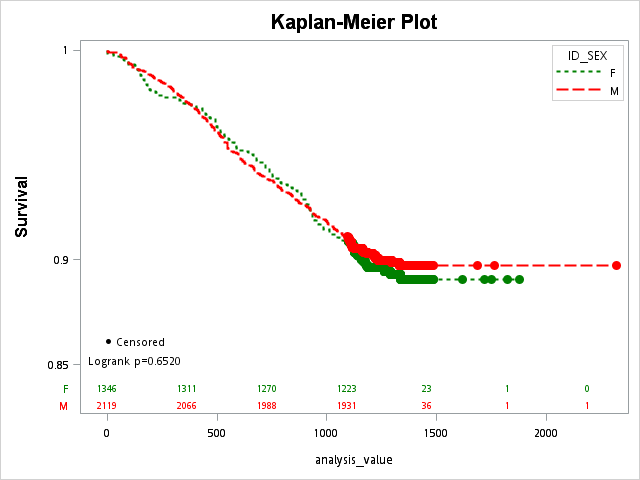

In [11]:
kmplot_command = """%macro km_plot_stroke_gender;   \
                    data NH.km_plot_stroke_gender;   \
                    set NH.Dd2008_target_stroke_surv (keep= ID_SEX  surv_first_interval  stroke_happen) ;   \
                    run;   \
                    data NH.km_plot_stroke_gender;   \
                    set NH.km_plot_stroke_gender (rename = ( surv_first_interval  = analysis_value  )) ;   \
                    if stroke_happen = 0 then censor = 1;   \
                    else if stroke_happen = 1 then censor = 0;    \
                    run;   \
                    data _null_;    \
                    %let url = //support.sas.com/documentation/onlinedoc/stat/ex_code/131;    \
                    infile "http:&url/templft.html" device=url;    \
                    file 'macros.tmp';    \
                    input;   \
                    if index(_infile_, '</pre>') then stop;   \
                    if pre then put _infile_;    \
                    if index(_infile_, '<pre>') then pre + 1;     \
                    run;    \
                    %inc 'macros.tmp' / nosource;    \
                    %ProvideSurvivalMacros     \
                    %let tatters = textattrs=(size=14pt weight=bold family='arial');       \
                    %let TitleText0 = "Kaplan-Meier Plot";       \
                    %let TitleText1 = &titletext0 " for " STRATUMID  / &tatters;       \
                    %let TitleText2 = &titletext0  / &tatters;       \
                    %let nTitles = 1;       \
                    %let LegendOpts = title=GROUPNAME location=inside across=1 autoalign=(TopRight);       \
                    %let InsetOpts = autoalign=(BottomLeft) border=false BackgroundColor=GraphWalls:Color Opaque=true;      \
                    %let yOptions = label="Survival"  labelattrs=(size=12pt weight=bold family='arial')    \
                        linearopts=(viewmin=0.85 viewmax=1 tickvaluelist=(0.85 0.9 1.0));    \
                    %let GraphOpts = DataContrastColors=(green red blue) DataColors=(green red blue)       \
                                             ATTRPRIORITY=NONE DataLinePatterns=(ShortDash MediumDash LongDash);       \
                    %let StepOpts = lineattrs=(thickness=2.5);        \
                    %let Censored = markerattrs=(symbol=circlefilled size=10px);       \
                    %let Censorstr = "(*ESC*){Unicode '25cf'x} Censored" ;       \
                    %CompileSurvivalTemplates       \
                    proc format;        \
                    value $ID_SEX        \
                    "F" = "Female"       \
                    "M" = "Male"     \
                    run;    \
                    ods graphics;     \
                    ods output survivalplot = survivalplot;     \
                    proc lifetest data = NH.km_plot_stroke_gender  notable   plots = survival(test atrisk(maxlen=13)  atrisk=0 to 2500 by 365);     \
                    time analysis_value  * censor(1);  /*event的話要改為(0)*/     \
                    strata ID_SEX;      \
                    run;      \
                    %ProvideSurvivalMacros     \
                    proc template;       \
                    delete Stat.Lifetest.Graphics.ProductLimitSurvival / store=sasuser.templat;      \
                    delete Stat.Lifetest.Graphics.ProductLimitSurvival2 / store=sasuser.templat;       \
                    run;      \
                    %mend km_plot_stroke_gender;     \
                    %km_plot_stroke_gender;"""

sas.submitLST(kmplot_command)

In [17]:
def show_html(input_content , name):
    f = open('{}.html'.format(name) , 'w')
    f.write(input_content)
    f.close()
    
kmplot = sas.submit(kmplot_command) 
show_html(kmplot['LST'] , 'kmplot_')    

### 住院天數
### 2008缺血性心臟病患者，分別在 2009、2010、2011 因為中風而住院天數計算   

In [12]:
# 住院天數
# 2008缺血性心臟病 在 2009 2010 2011 因為中風而住院的天數計算         
for i in range(2009 , 2011 + 1):  
    sas.submit("data NH.Dd2008_stroke_interval_hosp_{};   \
                set NH.Dd2008_target_stroke (keep = ID stroke_{} IN_DATE_{}  OUT_DATE_{} stroke_happen);   \
                run;".format(i , i , i , i))  
    
    sas.submit("data NH.Dd2008_stroke_interval_hosp_{};   \
                set NH.Dd2008_stroke_interval_hosp_{};   \
                if stroke_{} = 1 and OUT_DATE_{} and IN_DATE_{}  then do ;  \
                interval_hosp = input(OUT_DATE_{} , yymmdd8.) - input(IN_DATE_{} , yymmdd8.);  \
                output;  \
                end;  \
                run;".format(i , i , i , i , i , i , i))   

### 計算年齡平均 & 標準差 、性別比例

In [13]:
# 剔除掉重複ID，並取最後一筆
sas.submit("proc sort data = NH.Dd2008_target  \
            out = NH.Dd2008_avg_age;  \
            by ID;  \
            run;  \
            data NH.Dd2008_avg_age;  \
            set NH.Dd2008_avg_age;   \
            by ID;  \
            first = first.id;   \
            last = last.id;   \
            if last= 1 then output;   \
            run;")  

# 年齡平均 年齡標準差            
sas.submitLST("proc sql;    \
               select avg(age) as mean_age , std(age) as std_age \
               into :patient_mean_age , :patient_std_age  \
               from NH.Dd2008_avg_age ;   \
               quit;") 


# 計算病人總數
sas.submit("proc sql noprint;   \
            select count(age) as total_patient_num   \
            into :total_patient_num   \
            from NH.Dd2008_avg_age ;    \
            quit;") 

# 性別比例
sas.submitLST("proc sql; \
               select ID_sex , count(ID_sex) / &total_patient_num. as sex_percent  \
               from NH.Dd2008_avg_age  \
               group by ID_sex;   \
               quit;") 

mean_age,std_age
85.09293,10.68027


ID_SEX,sex_percent
F,0.388456
M,0.611544


### 針對2007年計算過去病史比例 
#### 目標對象很可能同時罹患不同疾病，所以應該是計算罹患某種疾病的目標佔全部目標對象的百分比

目標疾病 :  ```⾼⾎壓  ⾼⾎糖  ⾼⾎脂  慢性腎臟病  慢性阻塞性肺部疾病  ```

In [14]:
# For 2007 過去病史
string = ["('401' '402' '403' '404' '405')" ,                    # ⾼⾎壓
          "('250')" ,                                            # ⾼⾎糖 
          "('272')" ,                                            # ⾼⾎脂
          "('585')" ,                                            # 慢性腎臟病
          "('490' '491' ' 492' '493' '494' '495'  '496')"]       # 慢性阻塞性肺部疾病

# 創建 macro variable condition1_1 ~ condition5_4
for i in range(1 , 5 + 1):
    for j in range(1 , 4 + 1):
        if j == 1:            
            symput('condition{}_{}'.format(i , j) , 'substr(ICD9CM_CODE , 1 , 3)  in  {}'.format(string[i - 1]))
        else:
            symput('condition{}_{}'.format(i , j) , 'substr(ICD9CM_CODE_{} , 1 , 3)  in  {}'.format(j - 1 , string[i - 1]))
            
for i in range(1 , 5 + 1):
    for j in range(1 , 4 + 1):
        if i == 1 and j == 1:
            sas.submit("data NH.Dd2007_disease;  \
                        set NH.Dd2007 ;   \
                        if &condition{}_{}. then condition_{}_{} = 1;  \
                        else condition_{}_{} = 0;   \
                        run;".format(i , j , i , j , i , j))         
                           
        else:
            sas.submit("data NH.Dd2007_disease;  \
                        set NH.Dd2007_disease ;   \
                        if &condition{}_{}. then condition_{}_{} = 1;  \
                        else condition_{}_{} = 0;   \
                        run;".format(i , j , i , j , i , j)) 
            
# 累加 condition1_1 ~ condition5_4 
# 1.高血壓  2.高血糖  3.高血脂  4.慢性腎臟病  5.慢性阻塞性肺部疾病 
# 只要有罹患上述任一疾病，condition的值都會大於0 
sas.submit("data NH.Dd2007_disease;   \
            set NH.Dd2007_disease ;   \
            condition = 0 ;    \
            run;")  

for i in range(1 , 5 + 1):
    for j in range(1 , 4 + 1):
        sas.submit("data NH.Dd2007_disease;   \
                    set NH.Dd2007_disease ;   \
                    condition = condition + condition_{}_{} ;  \
                    run;".format(i , j))   
        
        # 高血壓(disease_1)  高血糖(disease_2) 高血脂(disease_3) 慢性腎臟病(disease_4) 慢性阻塞性肺部疾病(disease_5)
        # 上面這些疾病很可能重複得到 所以應該是計算某種疾病佔目標對象的百分比
        if j == 1:
            sas.submit("data NH.Dd2007_disease;    \
                        set NH.Dd2007_disease ;    \
                        disease_{} = condition_{}_{};  \
                        run;".format(i , i , j))
        else:
            sas.submit("data NH.Dd2007_disease;   \
                        set NH.Dd2007_disease ;   \
                        disease_{} = disease_{} + condition_{}_{} ;   \
                        run;".format(i , i , i , j))                   
        
    sas.submit("data NH.Dd2007_disease;      \
               set NH.Dd2007_disease ;       \
               if disease_{} > 0 then disease_{} = 1 ;    \
               run;".format(i , i))                

# 1.高血壓  2.高血糖  3.高血脂  4.慢性腎臟病  5.慢性阻塞性肺部疾病 
# 只要有罹患上述任一疾病，condition的值會大於0， condition 大於0的資料篩選出來                        
sas.submit("data NH.Dd2007_disease;   \
            set NH.Dd2007_disease ;   \
            if condition > 0 then output;    \
            run;")  

# 只挑選2008年罹患缺血性心臟病患者
sas.submit("proc sql;    \
            create table NH.Dd2007_disease as    \
            select *    \
            from NH.Dd2007_disease   \
            where ID in (select ID from NH.Dd2008_target_patient_list) ;   \
            quit;")  
 
sas.submit("data NH.Dd2007_disease_important;   \
            set NH.Dd2007_disease (keep = ID    ICD9CM_CODE    ICD9CM_CODE_1-ICD9CM_CODE_3    disease_1-disease_5   condition);   \
            run;")            


disease_percentage_list = []
for i in range(1 , 5 + 1):
    # 把同一個人罹患同一種疾病的資料去除掉
    sas.submit("proc sort nodupkey data = NH.Dd2007_disease   \
                out = NH.Dd2007_disease_{};     \
                by ID disease_{};     \
                run;".format(i , i))  

    # 把ID 跟 disease_i 留下來
    sas.submit("data NH.Dd2007_disease_{};      \
                set NH.Dd2007_disease_{}(keep = ID disease_{});    \
                run;".format(i , i , i))   

    # 把ID重複的刪去
    sas.submit("proc sort nodupkey data = NH.Dd2007_disease_{}   \
                out = NH.Dd2007_disease_{};     \
                by ID;    \
                run;".format(i , i))   
                  
    # 計算NH.Dd2007_disease_i有幾筆資料              
    sas.submit("proc sql noprint;   \
                select count(ID) as total_disease_row_{}   \
                into :  total_disease_row_{}   \
                from NH.Dd2007_disease_{} ;   \
                quit;".format(i , i , i))   
                 
    sas.symget('total_disease_row_{}'.format(i))             

    # disease_i為1的總數 / NH.Dd2007_disease_i資料數
    sas.submit("proc sql;  \
                select sum(disease_{}) / &&total_disease_row_{}  as disease_percentage_{}   \
                into :  disease_percentage_{}   \
                from NH.Dd2007_disease_{};     \
                quit;".format(i , i , i , i , i))
        
    
    if sas.symget('disease_percentage_{}'.format(i)) == '.':
        disease_percentage_list.append(0)
    else:    
        disease_percentage_list.append(sas.symget('disease_percentage_{}'.format(i)))

    
# 製作表格
disease_name_list = ['高血壓' , '高血糖' , '高血脂' , '慢性腎臟病' , '慢性阻塞性肺部疾病']
table_content = ''
for i , disease_percentage in enumerate(disease_percentage_list):    
    table_content += "values('{}', {})".format(disease_name_list[i] , disease_percentage_list[i])
sas.submitLST("proc sql;   \
               create table Nh.disease_percentage   \
               (disease char(20) , disease_percentage num);   \
               insert into    \
               Nh.disease_percentage    \
               (disease , disease_percentage)    \
               {}; \
               run;  \
               select *   \
               from Nh.disease_percentage;  \
               quit;".format(table_content)) 

disease,disease_percentage
高血壓,0.592133
高血糖,0.332298
高血脂,0.101449
慢性腎臟病,0.018634
慢性阻塞性肺部疾病,0.135611


### 針對2007年計算過去用藥史比例
#### 目標對象很可能同時使用數種藥物，所以應該是計算使用該種用藥的對象佔全部目標對象的百分比

目標用藥 : ```ANTIHYPERTENSIVE  bblocker  Metformin  Statin```

In [15]:
raed_csv(csv_path = "'{}\\{}\\{}'".format(os.getcwd() , 'SAS_dataset' , 'meditation.csv') , 
         libref = 'NH' , 
         name = 'meditation')

# 先把目標藥物挑出來
sas.submit("proc sql ;    \
            create table NH.drug_code_group as     \
            select distinct drug_code , drug_group    \
            from NH.meditation    \
            where drug_group in ('ANTIHYPERTENSIVE' , 'bblocker' , 'Metformin' , 'Statin');    \
            quit;")

# left join 人次與住院資訊 (DD 串 DO 即可得到每個人每次住院的所有資訊，串檔鍵值為：FEE_YM ＋ APPL_TYPE ＋ APPL_DATE ＋ CASE_TYPE ＋ SEQ_NO ＋ HOSP_ID)) 
# left join 用藥
# 再用where陳述把不相關的藥物剔除
sas.submit("proc sql;   \
            create table NH.Do2007_drug as    \
            select a.FEE_YM , a.APPL_TYPE , a.APPL_DATE , a.CASE_TYPE , a.SEQ_NO , a.HOSP_ID , a.ORDER_CODE , b.ID , c.drug_group   \
            from NH.Do2007 as a   \
            left join NH.Dd2007 as b     \
            on a.FEE_YM = b.FEE_YM and a.APPL_TYPE = b.APPL_TYPE and a.APPL_DATE = b.APPL_DATE  and a.CASE_TYPE = b.CASE_TYPE  and a.SEQ_NO = b.SEQ_NO and a.HOSP_ID = b.HOSP_ID   \
            left join NH.meditation as c    \
            on a.ORDER_CODE = c.drug_code     \
            where a.ORDER_CODE in (select drug_code from NH.drug_code_group) and b.ID in (select ID from NH.Dd2008_target_patient_list);     \
            quit;")

# ANTIHYPERTENSIVE(drug_1)  bblocker(drug_2)  Metformin(drug_3)  Statin(drug_4)
# 目標對象很可能同時服用drug_1 ~ drug_4 所以應該是計算某種用藥佔目標對象的百分比
sas.submit("data NH.Do2007_drug;      \
            set NH.Do2007_drug;       \
            if drug_group = 'ANTIHYPERTENSIVE'  then drug_1 = 1;    \
            if drug_group = 'bblocker'          then drug_2 = 1;    \
            if drug_group = 'Metformin'         then drug_3 = 1;    \
            if drug_group = 'Statin'            then drug_4 = 1;    \
            run;")

drug_percentage_list = []
for i in range(1 , 4 + 1):
    # 把同一個人用同一種藥的資料去除掉
    sas.submit("proc sort nodupkey data = NH.Do2007_drug   \
                out = NH.Do2007_drug_{};     \
                by ID drug_{};      \
                run;".format(i , i))
                 
    # 把ID 跟 drug_i 留下來             
    sas.submit("data NH.Do2007_drug_{};    \
                set NH.Do2007_drug_{} (keep = ID drug_{});   \
                run;".format(i , i , i))             

    # 把ID重複的刪去
    sas.submit("proc sort nodupkey data = NH.Do2007_drug_{}   \
                out = NH.Do2007_drug_{};    \
                by ID;    \
                run;".format(i , i))       

    # 計算NH.Do2007_drug_i有幾筆資料  
    sas.submit("proc sql noprint;     \
                select count(ID) as total_drug_row_{}    \
                into :  total_drug_row_{}    \
                from NH.Do2007_drug_{};\
                quit;".format(i , i , i))   
                 
    # drug_i為1的總數 / NH.Do2007_drug_i資料數
    sas.submit("proc sql;   \
                select sum(drug_{}) / &total_drug_row_{}. as drug_percentage_{}   \
                into :  drug_percentage_{}   \
                from NH.Do2007_drug_{}; \
                quit;".format(i , i , i , i , i))   
        
    if sas.symget('drug_percentage_{}'.format(i)) == '.':
        drug_percentage_list.append(0)
    else:    
        drug_percentage_list.append(sas.symget('drug_percentage_{}'.format(i)))

          
# 製作表格
drug_name_list = ['ANTIHYPERTENSIVE' , 'bblocker' , 'Metformin' , 'Statin']
table_content = ''
for i , disease_percentage in enumerate(drug_percentage_list):    
    table_content += "values('{}', {})".format(drug_name_list[i] , drug_percentage_list[i])       
sas.submitLST("proc sql;     \
               create table Nh.drug_percentage   \
               (drug char(20) , drug_percentage num);   \
               insert into   \
               Nh.drug_percentage  \
               (drug , drug_percentage)  \
               {}; \
               select *   \
               from Nh.drug_percentage;   \
               quit;".format(table_content))      

drug,drug_percentage
ANTIHYPERTENSIVE,0
bblocker,0.062201
Metformin,0.291866
Statin,0.416268
